# Saudi Containment and Closure Policies effects on COVID-19 Pandemic


## Importing Required Packages

In [2]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 5.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=cc299f00aedb041718f242246622b280c7b0b2e1e330d9cad270dbcff2d528e3
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [3]:
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error
import datetime
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import altair as alt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import missingno as msno
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from lime.lime_tabular import LimeTabularExplainer
import lime

warnings.filterwarnings("ignore")

## 1. Data Collection 

We have three datasets collected from different resources:
1. ICU Dataset (Source: MoH) <br>
2. Oxford Government Responce Tracker Dataset (source: Oxford uni) <br>
3. Daily COVID-19 Statistics (Source: Our World in Data) <br>

### 1.1 ICU Dataset

In [ ]:
# This will be the new dataset for the ICU Cases
ICU_data = pd.read_csv('https://raw.githubusercontent.com/alibrahim-hussain/capstone/main/ICU_Data.csv')

In [ ]:
ICU_data.head(5)

,Date,ICU Prev Cases,ICU Daily Cases,ICU Active Cases
0,02/03/2020,0,0,0
1,03/03/2020,0,0,0
2,04/03/2020,0,0,0
3,05/03/2020,0,0,0
4,06/03/2020,0,0,0


### 1.2 Oxford Dataset

In [4]:
# reading the dataset as pandas dataframe
ox_data = pd.read_csv('https://raw.githubusercontent.com/alibrahim-hussain/capstone/main/oxford.csv')

In [ ]:
# creating a subset of the data to include Saudi Arabia only
ox_data = ox_data[ox_data['CountryName'] == 'Saudi Arabia']

In [ ]:
ox_data.head(5)

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,date,C1_School closing,Date,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,V1_Vaccine Prioritisation (summary),V2A_Vaccine Availability (summary),V2B_Vaccine age eligibility/availability age floor (general population summary),V2C_Vaccine age eligibility/availability age floor (at risk summary),V2D_Medically/ clinically vulnerable (Non-elderly),V2E_Education,V2F_Frontline workers (non healthcare),V2G_Frontline workers (healthcare),V3_Vaccine Financial Support (summary),ConfirmedCases,ConfirmedDeaths,StringencyIndexForDisplay,StringencyLegacyIndexForDisplay,GovernmentResponseIndexForDisplay,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,Saudi Arabia,SAU,NaN,NaN,NAT_TOTAL,20200302,0,02/03/2020,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0,NaN,0,0.0,0.0,2,1,0,2,0.0,0,0,NaN,0,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,11.11,14.29,12.50,14.29,0.0,0.0
1,Saudi Arabia,SAU,NaN,NaN,NAT_TOTAL,20200303,0,03/03/2020,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0,NaN,0,0.0,0.0,2,1,0,2,0.0,0,0,NaN,0,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,11.11,14.29,12.50,14.29,0.0,0.0
2,Saudi Arabia,SAU,NaN,NaN,NAT_TOTAL,20200304,0,04/03/2020,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0,NaN,0,0.0,0.0,2,1,0,2,0.0,0,0,NaN,0,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,11.11,14.29,12.50,14.29,0.0,0.0
3,Saudi Arabia,SAU,NaN,NaN,NAT_TOTAL,20200305,0,05/03/2020,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0,NaN,0,0.0,0.0,2,1,2,2,0.0,0,0,NaN,0,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,5,0,11.11,14.29,16.67,19.05,0.0,0.0
4,Saudi Arabia,SAU,NaN,NaN,NAT_TOTAL,20200306,0,06/03/2020,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0,NaN,0,0.0,0.0,2,1,2,2,0.0,0,0,NaN,0,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,5,0,11.11,14.29,16.67,19.05,0.0,0.0


### 1.3 COVID-19 Dataset

In [ ]:
# Reading the dataset as pandas dataframe
covid_data = pd.read_csv('https://raw.githubusercontent.com/alibrahim-hussain/capstone/main/sa_covid.csv')


In [ ]:
covid_data.head()

,Date,new_cases,new_deaths,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_smoothed,positive_rate,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index
0,02/03/2020,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160,160,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11
1,03/03/2020,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240,400,0.011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11
2,04/03/2020,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,298,698,0.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11
3,05/03/2020,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,487,1185,0.034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11
4,06/03/2020,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1024,2209,0.063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11


## 2. Merging Datasets

### 2.1  Merging COVID-19 dataframe with ICU dataframe

In [ ]:
# New dataframe will be created by merging the two dataframes based on the date as both of them are
# reported on a daily bases 
covid_icu = pd.merge( covid_data ,ICU_data ,how = 'left', on  = 'Date')


In [ ]:
ICU_data.head()

,Date,ICU Prev Cases,ICU Daily Cases,ICU Active Cases
0,02/03/2020,0,0,0
1,03/03/2020,0,0,0
2,04/03/2020,0,0,0
3,05/03/2020,0,0,0
4,06/03/2020,0,0,0


In [ ]:
print("covid_data shape: ", covid_data.shape)
print("ICU_data shape: " ,ICU_data.shape)

covid_data shape:  (670, 30)
ICU_data shape:  (673, 4)


### 2.2  Merging covid_icu dataframe with oxford dataframe 

In [ ]:
final_data = pd.merge(covid_icu,ox_data, on = 'Date', how = 'left')

In [ ]:
final_data.head()

,Date,new_cases,new_deaths,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_smoothed,positive_rate,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,ICU Prev Cases,ICU Daily Cases,ICU Active Cases,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,date,C1_School closing,...,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,V1_Vaccine Prioritisation (summary),V2A_Vaccine Availability (summary),V2B_Vaccine age eligibility/availability age floor (general population summary),V2C_Vaccine age eligibility/availability age floor (at risk summary),V2D_Medically/ clinically vulnerable (Non-elderly),V2E_Education,V2F_Frontline workers (non healthcare),V2G_Frontline workers (healthcare),V3_Vaccine Financial Support (summary),ConfirmedCases,ConfirmedDeaths,StringencyIndexForDisplay,StringencyLegacyIndexForDisplay,GovernmentResponseIndexForDisplay,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,02/03/2020,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160,160,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11,0,0,0,Saudi Arabia,SAU,NaN,NaN,NAT_TOTAL,20200302,0,...,0,NaN,0,NaN,0,0,NaN,0,0.0,0.0,2,1,0,2,0.0,0,0,NaN,0,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,11.11,14.29,12.50,14.29,0.0,0.0
1,03/03/2020,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240,400,0.011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11,0,0,0,Saudi Arabia,SAU,NaN,NaN,NAT_TOTAL,20200303,0,...,0,NaN,0,NaN,0,0,NaN,0,0.0,0.0,2,1,0,2,0.0,0,0,NaN,0,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,11.11,14.29,12.50,14.29,0.0,0.0
2,04/03/2020,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,298,698,0.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11,0,0,0,Saudi Arabia,SAU,NaN,NaN,NAT_TOTAL,20200304,0,...,0,NaN,0,NaN,0,0,NaN,0,0.0,0.0,2,1,0,2,0.0,0,0,NaN,0,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,11.11,14.29,12.50,14.29,0.0,0.0
3,05/03/2020,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,487,1185,0.034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11,0,0,0,Saudi Arabia,SAU,NaN,NaN,NAT_TOTAL,20200305,0,...,0,NaN,0,NaN,0,0,NaN,0,0.0,0.0,2,1,2,2,0.0,0,0,NaN,0,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,5,0,11.11,14.29,16.67,19.05,0.0,0.0
4,06/03/2020,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1024,2209,0.063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11,0,0,0,Saudi Arabia,SAU,NaN,NaN,NAT_TOTAL,20200306,0,...,0,NaN,0,NaN,0,0,NaN,0,0.0,0.0,2,1,2,2,0.0,0,0,NaN,0,NaN,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,5,0,11.11,14.29,16.67,19.05,0.0,0.0


## 3. Data Pre-porcessing

### 3.2 Missing Data

 As vaccination data was recorded at the begging of 2021, we will replace all nan values with -1 as this is not a missing data

In [ ]:
final_data['total_vaccinations'] = final_data['total_vaccinations'].fillna(-1)
final_data['people_vaccinated'] = final_data['people_vaccinated'].fillna(-1)
final_data['people_fully_vaccinated'] = final_data['people_fully_vaccinated'].fillna(-1)
final_data['total_boosters'] = final_data['total_boosters'].fillna(-1)

In [ ]:
#Creating a function to calculte the missing values and return the features with >-40% missing data
def missingValuesHigh(dataset):
    missing_count = dataset.isnull().sum()
    percentage = round(100 * dataset.isnull().sum() / len(dataset),2)
    missing_values = pd.concat([missing_count , percentage], axis=1)
    missing_values = missing_values.rename(columns = {0 : 'Count',1 : 'Percentage'}).sort_values(by=['Percentage'],ascending=False)
    return missing_values[missing_values['Percentage']>= 40]
# Assigning the columns names to an array
high_missing = missingValuesHigh(final_data)

In [ ]:
high_missing

,Count,Percentage
M1_Wildcard,670,100.00
hosp_patients_per_million,670,100.00
RegionName,670,100.00
weekly_hosp_admissions_per_million,670,100.00
weekly_hosp_admissions,670,100.00
weekly_icu_admissions_per_million,670,100.00
weekly_icu_admissions,670,100.00
RegionCode,670,100.00
hosp_patients,670,100.00
icu_patients,670,100.00


In [ ]:
# dropping the columns of high missing values from the dataframe
final_data= final_data.drop(columns=high_missing.index.values, axis=1)

In [ ]:
pd.set_option('display.max_rows', 500)
#Creating a function to calculte the missing values and return the features with >-40% missing data
def missingValues(dataset):
    missing_count = dataset.isnull().sum()
    percentage = round(100 * dataset.isnull().sum() / len(dataset),2)
    missing_values = pd.concat([missing_count , percentage], axis=1)
    missing_values = missing_values.rename(columns = {0 : 'Count',1 : 'Percentage'}).sort_values(by=['Percentage'],ascending=False)
    return missing_values[missing_values['Count']> 0]
# Assigning the columns names to an array
missingValues(final_data)

,Count,Percentage
E1_Flag,162,24.18
H4_Emergency investment in healthcare,158,23.58
E3_Fiscal measures,158,23.58
E4_International support,158,23.58
H6_Flag,57,8.51
H8_Flag,44,6.57
EconomicSupportIndex,18,2.69
reproduction_rate,17,2.54
EconomicSupportIndexForDisplay,16,2.39
C4_Flag,14,2.09


### 3.1 Unrelated features

1. All "Flag" colummns, as this means if the policy is applied general in the conuntry or for a specific region, and in Saudi all the policies were applied in genral.
2. All 'E_' column, as this the econmic policies, and we are intersted on the health and governmental policies.

In [ ]:
flag_cols= ['E1_Flag','H6_Flag', 'H8_Flag','C4_Flag','C2_Flag','C3_Flag','C1_Flag','H1_Flag','H5_Investment in vaccines']

final_data= final_data.drop(columns=flag_cols, axis=1)


In [ ]:
ecom_cols = ['E3_Fiscal measures','E4_International support','EconomicSupportIndex','V3_Vaccine Financial Support (summary)',
            'EconomicSupportIndexForDisplay','E2_Debt/contract relief','E1_Income support','H4_Emergency investment in healthcare',
            'CountryCode', 'Jurisdiction']

final_data= final_data.drop(columns=ecom_cols, axis=1)



In [ ]:
# Un-important features as the index and duplicats for each dataset prior to merging 
del_cols = ['date','CountryName','ConfirmedCases','ConfirmedDeaths','V1_Vaccine Prioritisation (summary)', 'StringencyIndexForDisplay',
       'StringencyLegacyIndexForDisplay', 'GovernmentResponseIndexForDisplay','new_tests_smoothed',
       'ContainmentHealthIndexForDisplay','V2A_Vaccine Availability (summary)','stringency_index','total_tests_per_thousand','H1_Public information campaigns']
final_data= final_data.drop(columns=del_cols, axis=1)


In [ ]:
final_data['reproduction_rate'] = final_data['reproduction_rate'].fillna(method='bfill').fillna(method='ffill')
final_data['positive_rate'] = final_data['positive_rate'].fillna(method='bfill').fillna(method='ffill')

In [ ]:
missingValues(final_data)

,Count,Percentage


In [ ]:
final_data['new_deaths'] = final_data['new_deaths'].astype(int)

We don't have any missing values now

### 3.2 Feature Extraction

##### 3.2.1 Containment Index:
we will caculate the index for all the containment policy by diving the current value by the max value of that policy then taking the average. The index is out of 100.

In [ ]:
final_data['c_index'] = round((final_data['C1_School closing']/3) + (final_data['C2_Workplace closing']/3) +
                         (final_data['C3_Cancel public events']/2) +(final_data['C4_Restrictions on gatherings']/4)+
                         (final_data['C5_Close public transport']/2) +(final_data['C6_Stay at home requirements']/3)+
                         (final_data['C7_Restrictions on internal movement']/2) +(final_data['C8_International travel controls']/4)
                        )/8*100

##### 3.2.2 Health Index:
we will caculate the index for all the health policy by diving the current value by the max value of that policy then taking the average. The index is out of 100.

In [ ]:
final_data['h_index'] = round((final_data['H2_Testing policy']/3) +
                         (final_data['H3_Contact tracing']/2) +(final_data['C4_Restrictions on gatherings']/4)+
                         (final_data['H6_Facial Coverings']/4) +(final_data['H7_Vaccination policy']/5)+
                         (final_data['H8_Protection of elderly people']/3) 
                        )/6*100

## 4. EDA

In [ ]:
dfC = final_data.copy()
dfC['C1_School closing'] = dfC['C1_School closing'].replace({0.0: "No Policy", 1.0: "recommend closing or all schools open with alterations",
                                                2.0: "require closing (only some levels or categories)",
                                                 3.0: ' require closing all levels'})
dfC["C2_Workplace closing"] = dfC["C2_Workplace closing"].replace({0.0: "No Policy", 1.0: "recommend closing (or recommend work from home) or all businesses open with alterations",
                                                2.0: "require closing (or work from home) for some sectors or categories of workers",
                                                 3.0: 'require closing (or work from home) for all-but-essential workplaces'})
dfC["C3_Cancel public events"] = dfC["C3_Cancel public events"].replace({0.0: "No Policy", 1.0: "recommend cancelling",
                                                2.0: " require cancelling"})
dfC['C4_Restrictions on gatherings'] = dfC['C4_Restrictions on gatherings'].replace({0.0: "No Policy", 1.0: "estrictions on very large gatherings (limit 1000 people)",
                                                2.0: "restrictions on gatherings between 101-1000 people",
                                                 3.0: ' restrictions on gatherings between 11-100 peoples',
                                                4.0: "restrictions on gatherings of 10 people or less"})
dfC['C6_Stay at home requirements'] = dfC['C6_Stay at home requirements'].replace({0.0: "No Policy", 1.0: "recommend not leaving house",
                                                2.0: "require not leaving house with exceptions for 'essential' trips",
                                                3.0 : "require not leaving house with minimal exceptions"})
dfC['C7_Restrictions on internal movement'] = dfC['C7_Restrictions on internal movement'].replace({0.0: "No Policy", 1.0: "recommend not to travel between regions/cities",
                                                2.0: "internal movement restrictions in place"})
dfC['C8_International travel controls'] = dfC['C8_International travel controls'].replace({0.0: "No Policy", 1.0: "screening arrivals",
                                                2.0: "quarantine arrivals from some or all regions",
                                                3.0 : "ban arrivals from some regions",
                                                4.0 : "ban on all regions or total border closure"})

dfC["H6_Facial Coverings"] = dfC["H6_Facial Coverings"].replace({0.0: "No Policy", 1.0: "Recommended",
                                                 2.0: "Required in some specified places",
                                                 3.0: 'Required'})

dfC["H7_Vaccination policy"] = dfC["H7_Vaccination policy"].replace({0.0: "No Policy", 3.0: "Key Workers & Vulnerable Groups",
                                                 4.0: "Key Workers , Vulnerable Groups & selected Ages",
                                                 5.0: 'Available for all'})

dfC["H3_Contact tracing"] = dfC["H3_Contact tracing"].replace({0.0: "no contact tracing", 1.0: "limited contact tracing",
                                                 2.0: 'comprehensive contact tracing'})

dfC["H2_Testing policy"] = dfC["H2_Testing policy"].replace({0.0: "no testing policy", 2.0: "testing of anyone showing Covid-19 symptoms",
                                                 3.0: 'open public testing'})

In [ ]:
final_data

,Date,new_cases,new_deaths,reproduction_rate,new_tests,total_tests,positive_rate,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,ICU Prev Cases,ICU Daily Cases,ICU Active Cases,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings,H7_Vaccination policy,H8_Protection of elderly people,c_index,h_index
0,02/03/2020,1,0,1.98,160,160,0.0017,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.0,16.666667
1,03/03/2020,1,0,1.98,240,400,0.0017,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.0,16.666667
2,04/03/2020,1,0,1.98,298,698,0.0017,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.0,16.666667
3,05/03/2020,3,0,1.98,487,1185,0.0017,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,33.333333
4,06/03/2020,2,0,1.98,1024,2209,0.0017,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,33.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,27/12/2021,602,1,1.84,80804,32965869,0.0047,49953753.0,24972309.0,23101362.0,1880082.0,33,7,40,1,1,1,3,1,0,1,3,3,2,3,5,1,50.0,83.333333
666,28/12/2021,744,1,1.84,84060,33049929,0.0053,50215461.0,24986423.0,23125154.0,2103884.0,40,-1,39,1,1,1,3,1,0,1,3,3,2,3,5,1,50.0,83.333333
667,29/12/2021,752,1,1.84,84568,33134497,0.0060,50477457.0,25000071.0,23148114.0,2329272.0,39,4,43,1,1,1,3,1,0,1,3,3,2,3,5,1,50.0,83.333333
668,30/12/2021,819,2,1.84,95347,33229844,0.0067,50755660.0,25011556.0,23171018.0,2573086.0,43,6,49,1,1,1,3,1,0,1,3,3,2,3,5,1,50.0,83.333333


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


[Text(0, 0, 'No policy'), Text(0, 0, 'Recommended'), Text(0, 0, 'Required')]

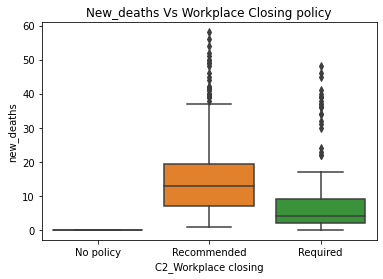

In [ ]:
ax = sns.boxplot('C2_Workplace closing', 'new_deaths', data= final_data)
ax.set_title('New_deaths Vs Workplace Closing policy')
ax.set_xticklabels(['No policy', 'Recommended','Required'])

In [ ]:

#ax = sns.boxplot(x='C2_Workplace closing', y='new_deaths', data=final_data, color='#99c2a2').set(title='New_deaths Vs Workplace Closing policy').set_xticklabels['No policy', 'Recommended','Required]
#ax = sns.swarmplot(x="C2_Workplace closing", y="new_deaths", data=final_data, color='#7d0013')
#plt.show()

In [ ]:
alt.Chart(final_data).transform_filter(
    "datum.total_vaccinations > -1").mark_circle(color='#669999').encode(

    x = alt.X('total_vaccinations'),
           
 
    y= alt.Y('new_deaths'),
    
    
).properties(title="New Deaths Vs Total Vaccination")

alt.Chart(...)

In [ ]:
covid_plt = final_data.copy()
covid_plt["H6_Facial Coverings"] = covid_plt["H6_Facial Coverings"].replace({0.0: "No Policy", 1.0: "Recommended",
                                                2.0: "Required in some specified places",
                                                 3.0: 'Required'})

alt.Chart(covid_plt).mark_line().encode(
    x='total_tests',
    y='positive_rate',
    color='H6_Facial Coverings',
    
).interactive().properties(title="Positive Rate Vs Total Tests")

alt.Chart(...)

In [ ]:
domain = ['No Policy', "recommend not leaving house",
                                                 "require not leaving house with exceptions for 'essential' trips",
                                               "require not leaving house with minimal exceptions"]
range_ = ['#A9BA9D', '#F8DE7E', '#01796F','#4F7942']


alt.Chart(dfC).mark_bar().encode(
    alt.Y(alt.repeat("column"), type='quantitative'),
    alt.X(alt.repeat("row"), type='nominal'),
    color=alt.Color('C6_Stay at home requirements:N',scale=alt.Scale(domain=domain, range=range_))
).properties(
    width=400,
    height=200,
    title = "Stay at home requirements policy vs Number of cases and Number of deaths ",

).repeat(
    row=['C6_Stay at home requirements'],
    column=['new_deaths','new_cases']
)


alt.RepeatChart(...)

In [ ]:
domain = ['No Policy',"screening arrivals",
    "quarantine arrivals from some or all regions",
          "ban arrivals from some regions","ban on all regions or total border closure"]
range_ = ['#A9BA9D', '#F8DE7E', '#01796F','#4F7942']

alt.Chart(dfC).mark_bar().encode(
    alt.Y(alt.repeat("column"), type='quantitative'),
    alt.X(alt.repeat("row"), type='nominal'),
    color=alt.Color('C8_International travel controls:N',scale=alt.Scale(domain=domain, range=range_))
).properties(
    width=400,
    height=200,
    title = "International travel controls policy vs Number of cases and Number of deaths ",

).repeat(
    row=['C8_International travel controls'],
    column=['new_deaths','new_cases']
).interactive()

alt.RepeatChart(...)

In [ ]:
domain = ['No Policy',"recommend not to travel between regions/cities",
                                               "internal movement restrictions in place"]
range_ = ['#A9BA9D', '#F8DE7E', '#01796F','#4F7942']


alt.Chart(dfC).mark_bar().encode(
    alt.Y(alt.repeat("column"), type='quantitative'),
    alt.X(alt.repeat("row"), type='nominal'),
    color=alt.Color('C7_Restrictions on internal movement:N',scale=alt.Scale(domain=domain, range=range_))
).properties(
    width=390,
    height=200,
    title = "Restrictions on internal movement policy vs Number of cases and Number of deaths ",
).repeat(
    row=['C7_Restrictions on internal movement'],
    column=['new_deaths','new_cases'],

).interactive()

alt.RepeatChart(...)

## Data Features Relations 

### 1. Correlation for continuas features and the target

In [ ]:
#final_data['new_deaths'].corr(final_data[['new_cases','reproduction_rate']])

con_col = final_data[['Date','new_cases','new_deaths' ,'reproduction_rate','new_tests','total_tests','positive_rate','total_vaccinations','people_vaccinated','people_fully_vaccinated','total_boosters','ICU Prev Cases','ICU Daily Cases','ICU Active Cases','c_index','h_index']]
con_col


,Date,new_cases,new_deaths,reproduction_rate,new_tests,total_tests,positive_rate,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,ICU Prev Cases,ICU Daily Cases,ICU Active Cases,c_index,h_index
0,02/03/2020,1,0,1.98,160,160,0.0017,-1.0,-1.0,-1.0,-1.0,0,0,0,0.0,16.666667
1,03/03/2020,1,0,1.98,240,400,0.0017,-1.0,-1.0,-1.0,-1.0,0,0,0,0.0,16.666667
2,04/03/2020,1,0,1.98,298,698,0.0017,-1.0,-1.0,-1.0,-1.0,0,0,0,0.0,16.666667
3,05/03/2020,3,0,1.98,487,1185,0.0017,-1.0,-1.0,-1.0,-1.0,0,0,0,0.0,33.333333
4,06/03/2020,2,0,1.98,1024,2209,0.0017,-1.0,-1.0,-1.0,-1.0,0,0,0,0.0,33.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,27/12/2021,602,1,1.84,80804,32965869,0.0047,49953753.0,24972309.0,23101362.0,1880082.0,33,7,40,50.0,83.333333
666,28/12/2021,744,1,1.84,84060,33049929,0.0053,50215461.0,24986423.0,23125154.0,2103884.0,40,-1,39,50.0,83.333333
667,29/12/2021,752,1,1.84,84568,33134497,0.0060,50477457.0,25000071.0,23148114.0,2329272.0,39,4,43,50.0,83.333333
668,30/12/2021,819,2,1.84,95347,33229844,0.0067,50755660.0,25011556.0,23171018.0,2573086.0,43,6,49,50.0,83.333333


In [ ]:
con_col.corrwith(con_col["new_deaths"]).sort_values(ascending=False)

new_deaths                 1.000000
ICU Active Cases           0.849335
ICU Prev Cases             0.849049
new_cases                  0.742894
positive_rate              0.451846
c_index                    0.175302
new_tests                  0.153990
ICU Daily Cases            0.005946
h_index                   -0.178200
total_boosters            -0.217209
reproduction_rate         -0.328532
people_vaccinated         -0.400088
people_fully_vaccinated   -0.428705
total_vaccinations        -0.434329
total_tests               -0.497297
dtype: float64

In [ ]:
corr = con_col.corr('pearson')

corr.style.background_gradient(cmap='coolwarm',)

,new_cases,new_deaths,reproduction_rate,new_tests,total_tests,positive_rate,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,ICU Prev Cases,ICU Daily Cases,ICU Active Cases,c_index,h_index
new_cases,1.000000,0.742894,-0.033402,0.062575,-0.442832,0.807802,-0.329566,-0.316481,-0.364080,-0.113552,0.720843,0.330106,0.731832,0.503036,-0.097243
new_deaths,0.742894,1.000000,-0.328532,0.153990,-0.497297,0.451846,-0.434329,-0.400088,-0.428705,-0.217209,0.849049,0.005946,0.849335,0.175302,-0.178200
reproduction_rate,-0.033402,-0.328532,1.000000,-0.439998,-0.297665,0.156753,-0.166570,-0.204987,-0.117899,0.335816,-0.438213,0.317718,-0.427776,0.229540,-0.437249
new_tests,0.062575,0.153990,-0.439998,1.000000,0.502909,-0.372260,0.283431,0.258075,0.081616,0.106915,0.500311,-0.197115,0.493865,-0.439958,0.547277
total_tests,-0.442832,-0.497297,-0.297665,0.502909,1.000000,-0.548277,0.901447,0.844808,0.806569,0.374412,-0.260669,-0.208967,-0.267582,-0.474573,0.701736
positive_rate,0.807802,0.451846,0.156753,-0.372260,-0.548277,1.000000,-0.345670,-0.313911,-0.300594,-0.119007,0.302950,0.445313,0.317674,0.796403,-0.264670
total_vaccinations,-0.329566,-0.434329,-0.166570,0.283431,0.901447,-0.345670,1.000000,0.959634,0.960018,0.457998,-0.303851,-0.184246,-0.309966,-0.269282,0.487723
people_vaccinated,-0.316481,-0.400088,-0.204987,0.258075,0.844808,-0.313911,0.959634,1.000000,0.940855,0.404719,-0.297292,-0.215731,-0.304451,-0.235721,0.394325
people_fully_vaccinated,-0.364080,-0.428705,-0.117899,0.081616,0.806569,-0.300594,0.960018,0.940855,1.000000,0.500164,-0.420298,-0.184886,-0.426447,-0.210799,0.385461
total_boosters,-0.113552,-0.217209,0.335816,0.106915,0.374412,-0.119007,0.457998,0.404719,0.500164,1.000000,-0.267941,0.010481,-0.267612,-0.084026,0.191927


### 2. Correlation for categorical features and the target

In [ ]:
from scipy.stats import f_oneway

def anova_test(feature):
    CategoryGroupLists=final_data.groupby(feature)['new_deaths'].apply(list)
    AnovaResults = f_oneway(*CategoryGroupLists)
    return print('P-Value for' ,feature , 'is: ',AnovaResults[1])


In [ ]:
anova_test('C1_School closing')
anova_test('C2_Workplace closing')
anova_test('C3_Cancel public events')
anova_test('C4_Restrictions on gatherings')
anova_test('C5_Close public transport')
anova_test('C7_Restrictions on internal movement')
anova_test('C6_Stay at home requirements')
anova_test('C8_International travel controls')
anova_test('H2_Testing policy')
anova_test('H3_Contact tracing')
anova_test('H6_Facial Coverings')
anova_test('H7_Vaccination policy')
anova_test('H8_Protection of elderly people')


P-Value for C1_School closing is:  1.0050648822271377e-32
P-Value for C2_Workplace closing is:  1.0557649490505762e-15
P-Value for C3_Cancel public events is:  2.249827806821038e-13
P-Value for C4_Restrictions on gatherings is:  1.099839022008826e-08
P-Value for C5_Close public transport is:  0.859757266855872
P-Value for C7_Restrictions on internal movement is:  0.003223387644119704
P-Value for C6_Stay at home requirements is:  1.1159360313307767e-143
P-Value for C8_International travel controls is:  2.037753670788157e-40
P-Value for H2_Testing policy is:  1.003241702854061e-10
P-Value for H3_Contact tracing is:  0.1193998671382537
P-Value for H6_Facial Coverings is:  1.2946645367908628e-29
P-Value for H7_Vaccination policy is:  3.4062616125460105e-56
P-Value for H8_Protection of elderly people is:  5.38812416848247e-16


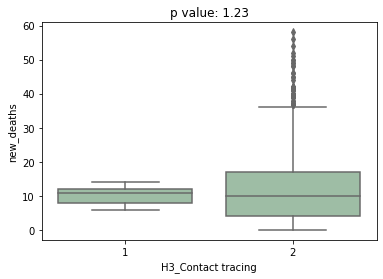

In [ ]:
ax = sns.boxplot(x='H3_Contact tracing', y='new_deaths', data=final_data, color='#99c2a2').set_title("p value: 1.23")


P-Value for H3_Contact tracing and C5_Close public transport are less than 0.05 this mean these feature doesn't have any signigcant effect on the new deaths 

## 5. Machine Learning Model

Splitting the dataset to training and testing set

In [ ]:
X = final_data.drop(['H3_Contact tracing','total_vaccinations','ICU Prev Cases','C5_Close public transport','ICU Active Cases','Date','new_deaths','c_index','new_tests','ICU Daily Cases','h_index'], axis=1)
y = final_data['new_deaths']


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42)


Sclating the data

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 5.1 Linear Regression Model

In [ ]:
# Constructing the model
reg = linear_model.LinearRegression()
# Fitting the training and testing data to the model
reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Linear Regreesion prediction
y_pred = reg.predict(X_test)

In [ ]:
reg_mse= np.sqrt(mean_squared_error(y_test,y_pred))
reg_r2 = r2_score(y_test, y_pred)
print('MSE: ', reg_mse)
print('R2: ', reg_r2)

MSE:  3.9361198224851344
R2:  0.8964581055749643


## Lasso

In [ ]:
# Constructing the model
lasso = linear_model.Lasso(alpha=0.1)
# Fitting the training and testing data to the model
lasso.fit(X_train, y_train)
# Linear Regreesion prediction
y_pred_lasso = lasso.predict(X_test)
lasso_mse = np.sqrt(mean_squared_error(y_test,y_pred_lasso))
lasso_r2 = r2_score(y_test, y_pred_lasso)

print('MSE: ', lasso_mse)
print('R2: ', lasso_r2)


MSE:  4.0392761911667625
R2:  0.8909598137325551


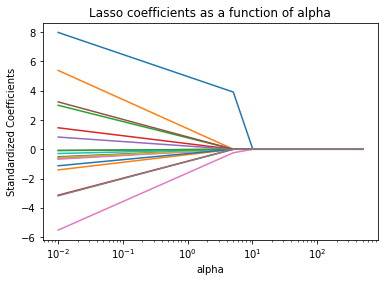

In [ ]:
alphas = np.linspace(0.01,500,100)
lasso = linear_model.Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

## 5.3 Lasso with Grid Search

In [ ]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score:  0.9104053603070781
Best Params:  {'alpha': 0.01}


In [ ]:
# from sklearn.svm import SVR
# reg_svr = SVR(kernel = 'linear')
# reg_svr.fit(X_train, y_train)

# preds_svr = reg_svr.predict(X_test)
# mean_absolute_error(y_true=y_test, y_pred=preds_svr)



In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

reg_svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
reg_svr.fit(X, y)
preds_svr = reg_svr.predict(X_test)


In [ ]:
print(r2_score(y_test, preds_svr))

-0.1921898205665289


### Random Forest

In [ ]:
reg_forest = RandomForestRegressor(n_estimators = 10, max_depth = 10, criterion = 'mse')
reg_forest.fit(X_train, y_train)

preds_forest = reg_forest.predict(X_test)
rf_mse = np.sqrt(mean_squared_error(y_test,preds_forest))

print(r2_score(y_test, preds_forest))
print('MSE: ', rf_mse)


0.9664550585726527
MSE:  2.24039077765654


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
print(rf_random.best_params_)
print('Best Score: ', rf_random.best_score_)


{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}
Best Score:  0.9616291383068472


In [ ]:
# Decision Trees

In [ ]:
reg_tree = DecisionTreeRegressor(random_state = 0, max_depth= 7, criterion= 'mse')
reg_tree.fit(X_train, y_train)

preds_tree = reg_tree.predict(X_test)

In [ ]:
tree_mse = np.sqrt(mean_squared_error(y_test,preds_tree))
tree_r2 = r2_score(y_test, preds_tree)
print('tree_mse: ', tree_mse)
print('tree_r2: ', tree_r2)

In [ ]:
# constructin the LIME tabular explaination and fitting the training data
X_featurenames = X.columns

explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                    feature_names=X_featurenames, 
                    # selecting the categorical features by index
                   categorical_features= [10,11,12,13,14,15,16,17,18,19,20],
                    verbose=True, mode='regression')
# Trying to explain one prediction
exp = explainer.explain_instance(X_test[19], reg_tree.predict)
#474
